In [9]:
from golem.core.tuning.sequential import SequentialTuner
from golem.core.tuning.simultaneous import SimultaneousTuner, HyperoptTuner

from copy import deepcopy
import optuna
from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.repository.tasks import Task, TaskTypesEnum
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot.core.composer.metrics import F1
from fedot.core.optimisers.objective import MetricsObjective, PipelineObjectiveEvaluate
from fedot.core.optimisers.objective.data_source_splitter import DataSourceSplitter
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum
from fedot.core.repository.dataset_types import DataTypesEnum

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
from sklearn.ensemble import IsolationForest

def check_anomaly(data):
    iso_forest = IsolationForest(n_estimators=100, random_state=42)
    iso_forest.fit(data)
    outliers_mask = iso_forest.predict(data) == 1
    return data.loc[outliers_mask]

In [11]:
import pandas as pd 
import numpy as np
train = pd.read_csv('data/train.csv')
train.replace(['-9999', -9999], np.nan, inplace=True)
test = pd.concat([pd.read_csv('data/test.csv'), pd.read_csv('data/real_test_result.csv')], axis=1)
test.replace(['-9999', -9999], np.nan, inplace=True)


In [12]:

features =  ['DEN', 'GR', 'NEU', 'PEF', 'RDEP']
targets = list(train.columns.values[-3:])
col_names =  ['DEN', 'GR', 'NEU', 'PEF', 'RDEP'] + list(train.columns.values[-3:])
train.replace(['-9999', -9999], np.nan, inplace=True)
train.dropna(axis=0, subset=col_names, inplace=True)
# remove all rows that contains missing value 

clf = IsolationForest(random_state=0).fit_predict(train[col_names])
train = train[clf==1]
train

,WELLNUM,DEPTH,DTC,DTS,BS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,ROP,PHIF,SW,VSH
97641,2,11645.67,74.68570,129.4712,8.5,8.601600,2.480500,0.046900,38.43410,0.185700,0.04690,0.956100,1.15780,28.4429,0.109000,1.0000,0.2336
250286,6,14987.21,NaN,NaN,8.5,8.703100,2.393500,0.080000,49.90450,0.235400,4.86610,3.573600,3.17040,24.8186,0.147000,0.5570,0.3680
168191,4,12625.98,NaN,NaN,8.5,8.556900,2.210600,0.040700,46.90850,0.219900,5.25040,3.578900,3.85550,23.3812,0.248600,0.3377,0.3532
168275,4,12653.54,NaN,NaN,8.5,8.556900,2.245200,0.038100,33.43740,0.200900,5.28080,3.704000,5.53960,29.7593,0.229100,0.3037,0.2340
251239,6,15299.87,NaN,NaN,8.5,8.718800,2.383000,0.082500,11.68570,0.079300,4.23790,8.408200,13.00560,10.0254,0.133000,0.3100,0.0550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316195,8,10759.00,67.43977,NaN,8.5,8.502293,2.567919,0.028003,12.63961,0.107874,5.68731,3.582837,3.46704,23.4428,0.055471,1.0000,0.0938
129373,3,10615.81,87.50470,NaN,8.5,8.697600,2.468500,0.053500,84.84280,0.268800,6.57070,1.143000,1.06540,22.6093,0.115400,1.0000,0.6387
246675,6,13802.49,NaN,NaN,8.5,8.625000,2.167800,0.046000,26.59000,0.206300,4.25240,28.601200,36.66780,30.0044,0.258000,0.1280,0.1770
241653,6,12154.86,NaN,NaN,8.5,8.625000,2.191900,0.051000,16.38590,0.168700,4.34950,76.864800,77.27250,29.9841,0.235000,0.1010,0.0930


In [13]:
train

,WELLNUM,DEPTH,DTC,DTS,BS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,ROP,PHIF,SW,VSH
97641,2,11645.67,74.68570,129.4712,8.5,8.601600,2.480500,0.046900,38.43410,0.185700,0.04690,0.956100,1.15780,28.4429,0.109000,1.0000,0.2336
250286,6,14987.21,NaN,NaN,8.5,8.703100,2.393500,0.080000,49.90450,0.235400,4.86610,3.573600,3.17040,24.8186,0.147000,0.5570,0.3680
168191,4,12625.98,NaN,NaN,8.5,8.556900,2.210600,0.040700,46.90850,0.219900,5.25040,3.578900,3.85550,23.3812,0.248600,0.3377,0.3532
168275,4,12653.54,NaN,NaN,8.5,8.556900,2.245200,0.038100,33.43740,0.200900,5.28080,3.704000,5.53960,29.7593,0.229100,0.3037,0.2340
251239,6,15299.87,NaN,NaN,8.5,8.718800,2.383000,0.082500,11.68570,0.079300,4.23790,8.408200,13.00560,10.0254,0.133000,0.3100,0.0550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316195,8,10759.00,67.43977,NaN,8.5,8.502293,2.567919,0.028003,12.63961,0.107874,5.68731,3.582837,3.46704,23.4428,0.055471,1.0000,0.0938
129373,3,10615.81,87.50470,NaN,8.5,8.697600,2.468500,0.053500,84.84280,0.268800,6.57070,1.143000,1.06540,22.6093,0.115400,1.0000,0.6387
246675,6,13802.49,NaN,NaN,8.5,8.625000,2.167800,0.046000,26.59000,0.206300,4.25240,28.601200,36.66780,30.0044,0.258000,0.1280,0.1770
241653,6,12154.86,NaN,NaN,8.5,8.625000,2.191900,0.051000,16.38590,0.168700,4.34950,76.864800,77.27250,29.9841,0.235000,0.1010,0.0930


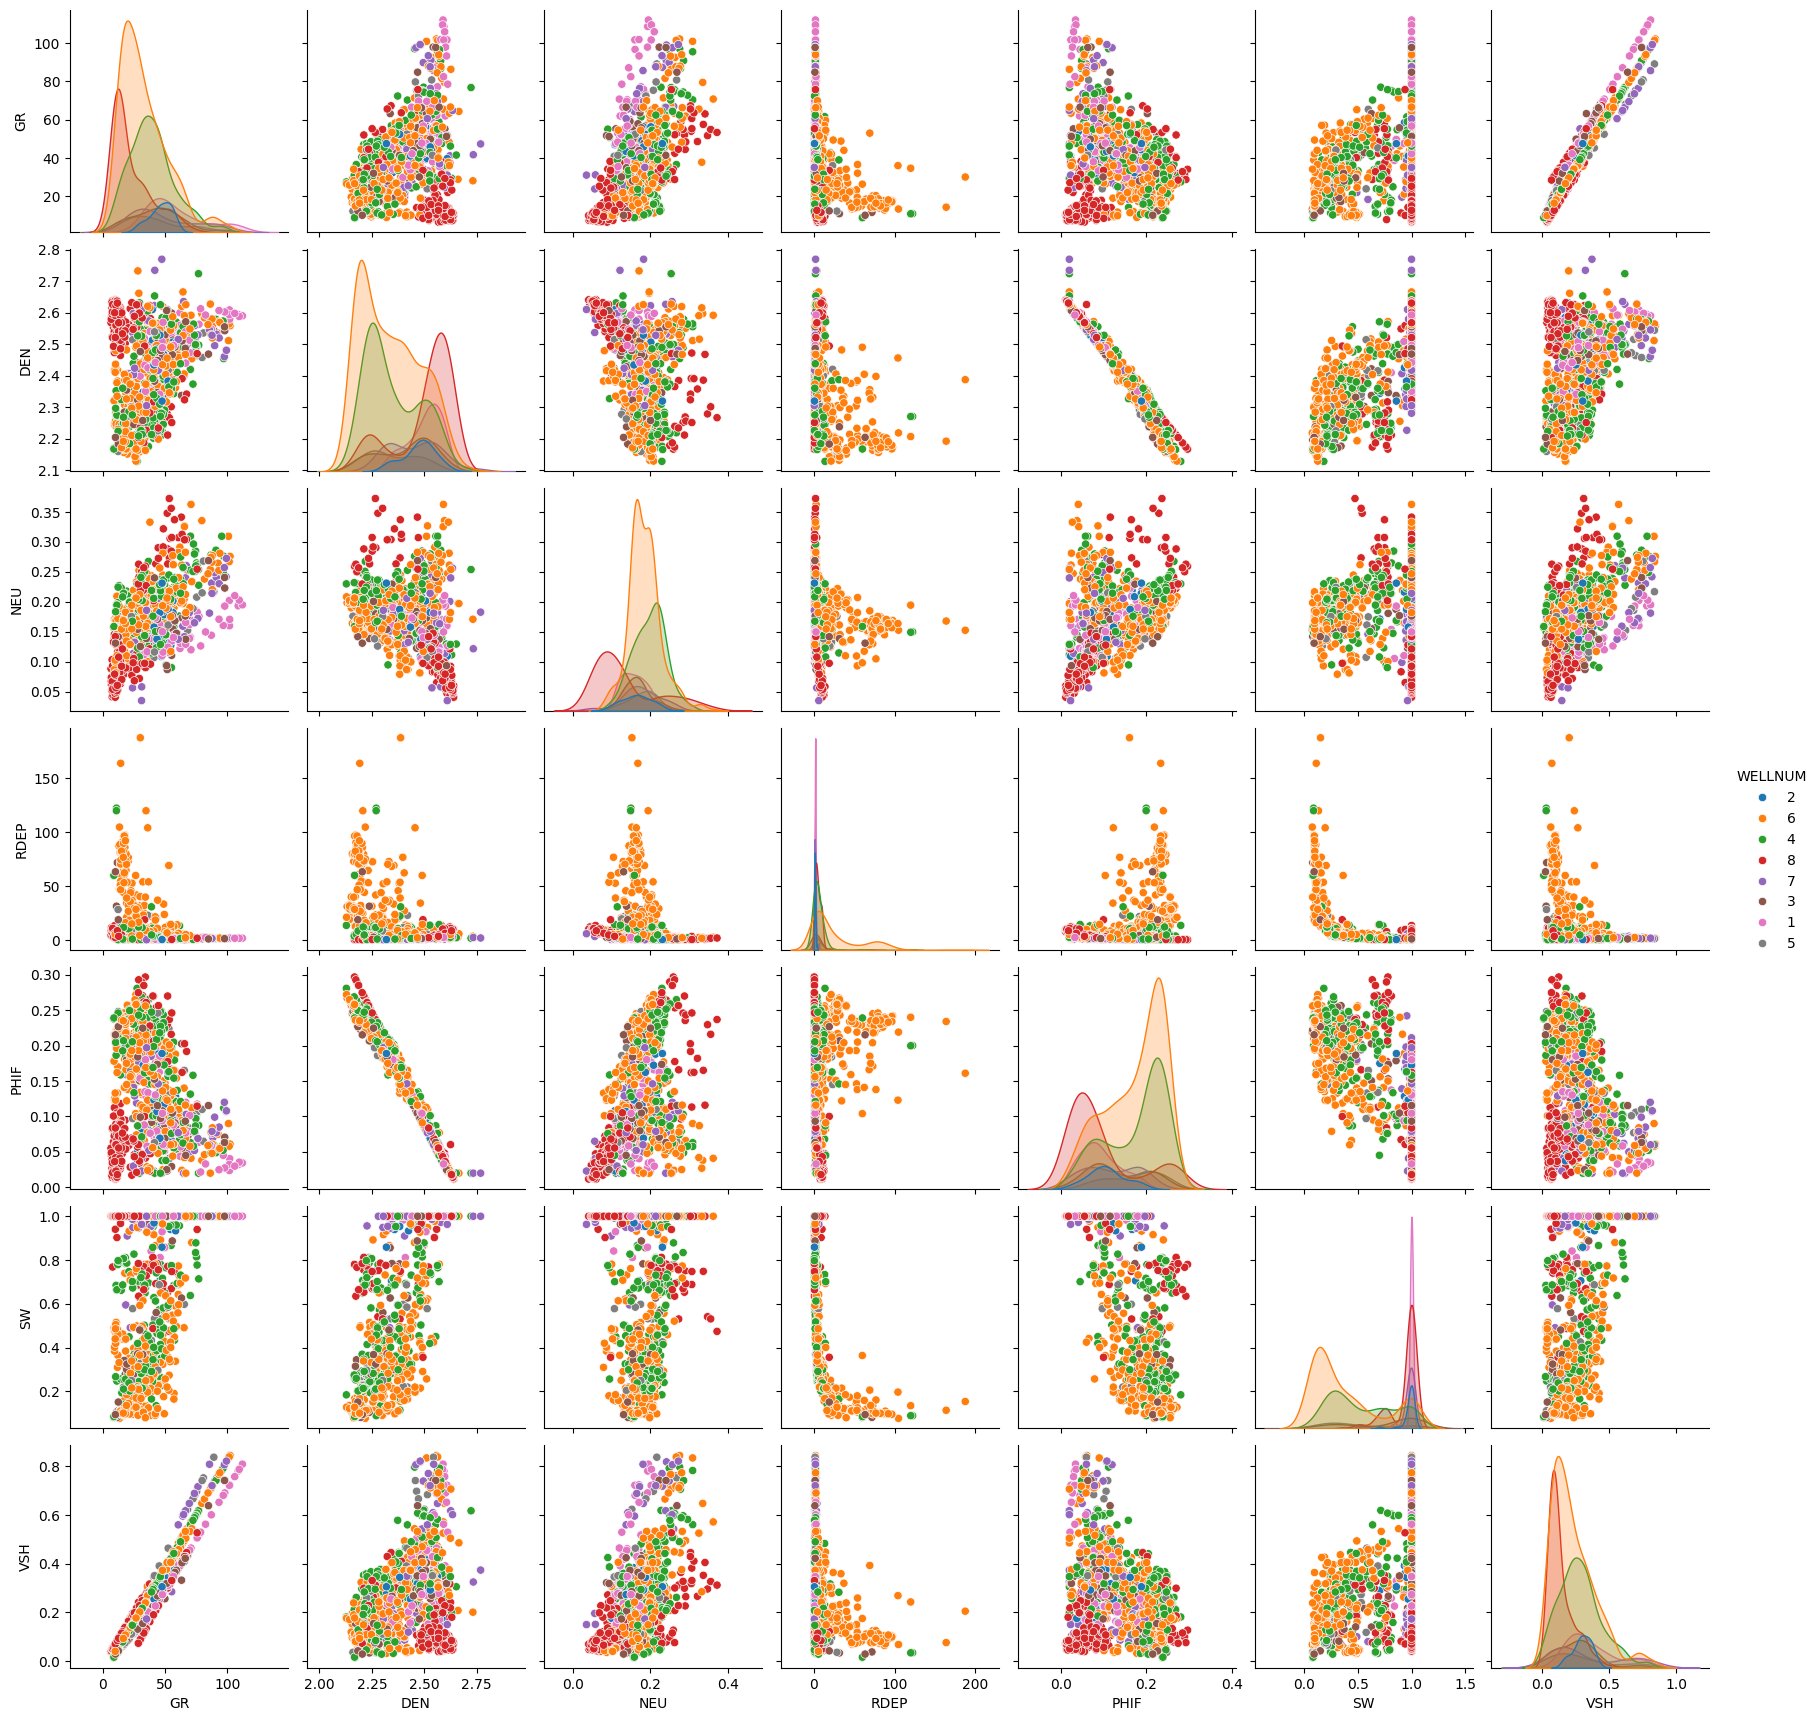

In [14]:
import seaborn as sns
df_new = train.copy()
df_new['WELLNUM'] = train['WELLNUM'].astype('str')
sns.pairplot(df_new[['WELLNUM', 'GR', 'DEN', 'NEU', 'RDEP', 'PHIF', 'SW', 'VSH']], hue='WELLNUM')

In [15]:


def select_pipeline(target):
    
    
    model = Fedot(problem='regression', metric='rmse')
    best_pipeline = model.fit(features=train[col_names], target=target)

    
    return best_pipeline, model, 

d:\repos\IndustrialIILab\lab1\venv\Lib\site-packages\fedot\preprocessing\preprocessing.py:361: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: x.strip() if isinstance(x, str) else x)


2023-11-05 11:52:14,588 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 161.0 MiB, max: 333.8 MiB
2023-11-05 11:52:14,590 - ApiComposer - Initial pipeline was fitted in 1.4 sec.
2023-11-05 11:52:14,591 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-11-05 11:52:14,596 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 5.0 min. Set of candidate models: ['rfr', 'adareg', 'treg', 'gbr', 'ridge', 'svr', 'linear', 'sgdr', 'ransac_non_lin_reg', 'normalization', 'lgbmreg', 'scaling', 'ransac_lin_reg', 'pca', 'lasso', 'dtreg', 'poly_features', 'isolation_forest_reg', 'knnreg', 'fast_ica'].
2023-11-05 11:52:14,599 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-11-05 11:52:19,737 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2023-11-05 11:52:48,717 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-11-05 11:53:01,132 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-11-05 11:53:06,864 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-11-05 11:53:17,189 - MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.
2023-11-05 11:53:31,264 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-11-05 11:54:31,069 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-11-05 11:55:30,785 - MultiprocessingDispatcher - 54 individuals out of 54 in pre

Generations:   0%|          | 1/10000 [04:34<?, ?gen/s]


2023-11-05 11:56:49,715 - ApiComposer - Model generation finished
2023-11-05 11:56:51,491 - FEDOT logger - Final pipeline was fitted
2023-11-05 11:56:51,493 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [treg, poly_features, scaling]}
treg - {}
poly_features - {}
scaling - {}
2023-11-05 11:56:51,494 - MemoryAnalytics - Memory consumption for finish in main session: current 160.2 MiB, max: 333.8 MiB
Pipeline structure:
{'depth': 3, 'length': 3, 'nodes': [treg, poly_features, scaling]}
treg - {}
poly_features - {}
scaling - {}
None


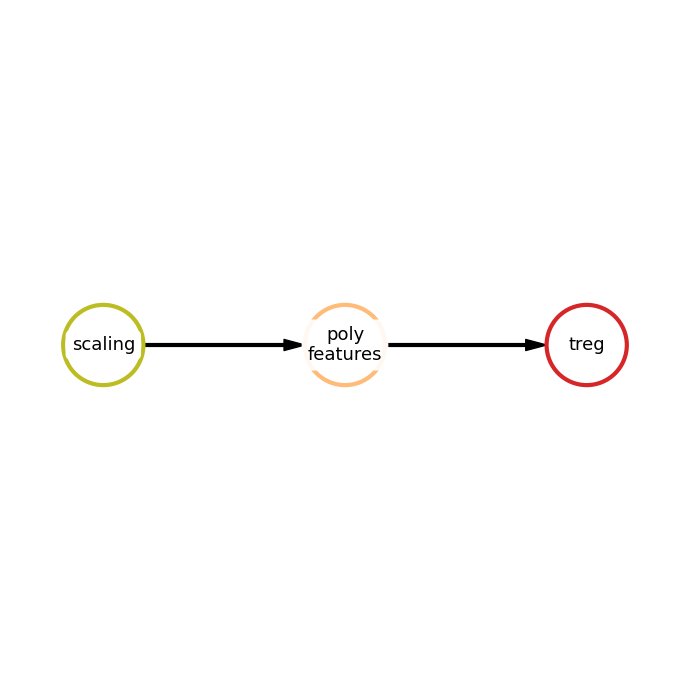

In [17]:
PHIF_pipleine, PHIF_model = select_pipeline("PHIF")
print(PHIF_pipleine.print_structure())

PHIF_pipleine.show()

In [ ]:
def tune_pipeline(pipeline, target):
    train_data = InputData(idx=list(train.index),
                       features=train[features].values,
                       target=train[target].values,
                       task=Task(TaskTypesEnum.regression),
                       data_type=DataTypesEnum.table)
    
    opt_tuner = (TunerBuilder(Task(TaskTypesEnum.regression))
                .with_tuner(SimultaneousTuner)
                .with_cv_folds(3)
                .with_n_jobs(-1)
                .with_metric(metric=RegressionMetricsEnum.RMSE)
                .with_iterations(50)
                .build(train_data))
    
    fig = optuna.visualization.plot_optimization_history(opt_tuner.study)
    fig.show()

    opt_pipeline = opt_tuner.tune(deepcopy(pipeline))
    return opt_pipeline, opt_tuner

In [61]:
pipeline = PipelineBuilder().add_sequence('scaling', 'poly_features', 'treg').build()

In [ ]:
PHIF_pipleine = tune_pipeline(pipeline, "PHIF")


In [63]:
train_data = InputData(idx=list(train.index),
                       features=train[features].values,
                       target=train["PHIF"].values,
                       task=Task(TaskTypesEnum.regression),
                       data_type=DataTypesEnum.table)

In [64]:
PHIF_pipleine.fit(train_data)


d:\repos\IndustrialIILab\lab1\venv\Lib\site-packages\fedot\preprocessing\preprocessing.py:361: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: x.strip() if isinstance(x, str) else x)


OutputData(idx=array([ 97641, 250286, 168191, 168275, 251239, 316735, 315504, 294516,
       318450, 245956, 250609, 168981, 164508, 243905, 239428, 163594,
       251065, 249494, 131100, 248094,  96901, 162355, 168937, 165142,
       162262,  98046, 165549, 246796, 241885, 247111,  62252, 248524,
       205034, 244325, 167594, 250235, 169357, 130793, 315276,  63595,
       238921, 205274, 317490,  97598, 245918, 295164, 315149, 249660,
        97831, 129815, 250017, 313669, 239979, 248505, 294293, 166328,
       129748, 250101,  62198, 238956, 129751, 317328,  63361, 239116,
       241839, 238800, 164836, 248568, 317904, 205638, 294466,  61957,
       238972, 249533, 311928, 316885, 240828, 251035, 169247,  62318,
       295196, 251380, 251709, 248129, 168308, 250605, 315447, 250546,
       169781, 295090, 205145, 240390, 165404,  61221, 205601, 245015,
       317374,  61724, 162645, 314931, 243335, 206057, 293839, 314102,
       294797, 130378, 318278, 245269, 168168, 247958, 163002,

In [65]:
test_data = InputData(idx=list(test.index),
                       features=test[features].values,
                       task=Task(TaskTypesEnum.regression),
                       data_type=DataTypesEnum.table)

In [74]:

predict = PHIF_pipleine.predict(test_data)


d:\repos\IndustrialIILab\lab1\venv\Lib\site-packages\fedot\preprocessing\preprocessing.py:361: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [78]:
predict.predict

array([0.06899308, 0.07912399, 0.09168262, ..., 0.145412  , 0.14960154,
       0.160875  ])

In [79]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test['PHIF'], predict.predict)

0.0004024721965354759

In [59]:
test['PHIF']

0        0.066265
1        0.084434
2        0.089096
3        0.048931
4        0.066265
           ...   
11270    0.144900
11271    0.144500
11272    0.150300
11273    0.155800
11274    0.161600
Name: PHIF, Length: 11275, dtype: float64

In [57]:
predict.target

array([[0.066265],
       [0.084434],
       [0.089096],
       ...,
       [0.1503  ],
       [0.1558  ],
       [0.1616  ]])

In [45]:

PHIF_pipleine.predict(test)

print(PHIF_pipleine.get_metrics(target=test["PHIF"]))

Pipeline structure:
{'depth': 3, 'length': 3, 'nodes': [treg, poly_features, scaling]}
treg - {}
poly_features - {}
scaling - {}
2023-11-05 13:21:57,784 - Pipeline - Pipeline is not fitted yet


ValueError: Pipeline is not fitted yet

In [ ]:
SW_pipeline, SW_model = select_pipeline("SW")
SW_pipeline.show()

d:\repos\IndustrialIILab\lab1\venv\Lib\site-packages\fedot\preprocessing\preprocessing.py:361: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: x.strip() if isinstance(x, str) else x)


2023-11-04 21:04:03,139 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 8.3 MiB, max: 268.5 MiB
2023-11-04 21:04:03,141 - ApiComposer - Initial pipeline was fitted in 47.6 sec.
2023-11-04 21:04:03,142 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-11-04 21:04:03,148 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 5.0 min. Set of candidate models: ['adareg', 'isolation_forest_reg', 'lgbmreg', 'knnreg', 'ridge', 'normalization', 'dtreg', 'poly_features', 'lasso', 'fast_ica', 'treg', 'rfr', 'gbr', 'linear', 'ransac_lin_reg', 'pca', 'sgdr', 'svr', 'scaling', 'ransac_non_lin_reg'].
2023-11-04 21:04:03,151 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-11-04 21:04:44,227 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2023-11-04 21:51:35,219 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-11-04 21:51:35,261 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [47:32<?, ?gen/s]

2023-11-04 21:51:35,370 - ApiComposer - Model generation finished


2023-11-04 21:51:47,293 - FEDOT logger - Final pipeline was fitted
2023-11-04 21:51:47,295 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [treg, scaling]}
treg - {}
scaling - {}
2023-11-04 21:51:47,296 - MemoryAnalytics - Memory consumption for finish in main session: current 11.2 MiB, max: 268.5 MiB


In [ ]:
SW_model.get_metrics()

{'rmse': 9.223372036854776e+18}

In [ ]:
VSH_pipeline, VSH_model = select_pipeline("VSH")
VSH_pipeline.show()

d:\repos\IndustrialIILab\lab1\venv\Lib\site-packages\fedot\preprocessing\preprocessing.py:361: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: x.strip() if isinstance(x, str) else x)


2023-11-04 23:04:32,490 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 15576.5 MiB, max: 31052.7 MiB
2023-11-04 23:04:32,493 - ApiComposer - Initial pipeline was fitted in 58.3 sec.
2023-11-04 23:04:32,494 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.
2023-11-04 23:04:32,501 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 5.0 min. Set of candidate models: ['adareg', 'lasso', 'rfr', 'knnreg', 'ridge', 'normalization', 'linear', 'ransac_lin_reg', 'pca', 'dtreg', 'sgdr', 'scaling', 'ransac_non_lin_reg'].
2023-11-04 23:04:32,506 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-11-04 23:05:29,019 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2023-11-04 23:12:19,829 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-11-04 23:12:19,903 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [07:47<?, ?gen/s]


2023-11-04 23:12:20,450 - ApiComposer - Model generation finished
2023-11-04 23:13:44,135 - FEDOT logger - Final pipeline was fitted
2023-11-04 23:13:44,138 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [rfr, normalization]}
rfr - {'n_jobs': 16}
normalization - {}
2023-11-04 23:13:44,140 - MemoryAnalytics - Memory consumption for finish in main session: current 15578.1 MiB, max: 31052.7 MiB


In [ ]:
VSH_model.get_metrics()

{'rmse': 9.223372036854776e+18}

In [ ]:
test

,WELLNUM,DEPTH,DTC,DTS,BS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,ROP,PHIF,SW,VSH
0,100,15912.5,65.46309,NaN,8.5,8.275658,2.545791,0.051429,9.791040,0.134139,5.858729,2.881351,2.645010,262.28170,0.066265,1.0000,0.0000
1,100,15913.0,64.56976,NaN,8.5,8.275658,2.524871,0.043547,11.278870,0.111488,6.021325,2.881351,2.645010,262.03700,0.084434,1.0000,0.0000
2,100,15913.5,64.43656,NaN,8.5,8.275658,2.507431,0.037683,9.954506,0.112143,6.060280,3.027379,2.928987,261.98810,0.089096,1.0000,0.0000
3,100,15914.0,65.03485,NaN,8.5,8.275658,2.575224,0.064832,8.630137,0.114846,6.202412,3.054653,2.974949,261.71960,0.048931,1.0000,0.0000
4,100,15914.5,65.13235,NaN,8.5,8.286819,2.550074,0.017329,7.305769,0.116967,5.179704,3.054653,2.974949,261.52470,0.066265,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11270,104,12393.5,NaN,NaN,8.5,8.506509,2.420993,0.042955,35.404900,0.140171,3.147515,0.823107,0.851536,22.95434,0.144900,0.9338,0.2643
11271,104,12394.0,NaN,NaN,8.5,8.486116,2.418174,0.040389,35.706500,0.138998,3.198371,0.749731,0.792532,22.78389,0.144500,0.9714,0.2670
11272,104,12394.5,NaN,NaN,8.5,8.499702,2.414918,0.044340,33.683400,0.144701,3.269237,0.706435,0.704768,22.67181,0.150300,0.9586,0.2491
11273,104,12395.0,NaN,NaN,8.5,8.511973,2.403496,0.041928,32.255100,0.150501,3.206371,0.715481,0.678997,22.41259,0.155800,0.9236,0.2374


In [29]:
test = pd.concat([pd.read_csv('data/test.csv'), pd.read_csv('data/real_test_result.csv')], axis=1)
test.replace(['-9999', -9999], np.nan, inplace=True)

In [34]:

from sklearn.metrics import mean_squared_error
def calc_rmse(model, target):
    y_test = test[target]
    c_test = test

    y_pred = model.predict(c_test)
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [35]:
calc_rmse(PHIF_model, "PHIF")

d:\repos\IndustrialIILab\lab1\venv\Lib\site-packages\fedot\preprocessing\preprocessing.py:361: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: x.strip() if isinstance(x, str) else x)


0.14205687615026102

In [ ]:
print((calc_rmse(VSH_model, "VSH")+calc_rmse(SW_model, "SW") + calc_rmse(PHIF_model, "PHIF"))/3)

d:\repos\IndustrialIILab\lab1\venv\Lib\site-packages\fedot\preprocessing\preprocessing.py:361: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: x.strip() if isinstance(x, str) else x)
d:\repos\IndustrialIILab\lab1\venv\Lib\site-packages\fedot\preprocessing\preprocessing.py:361: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: x.strip() if isinstance(x, str) else x)
d:\repos\IndustrialIILab\lab1\venv\Lib\site-packages\fedot\preprocessing\preprocessing.py:361: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: x.strip() if isinstance(x, str) else x)


0.1888775846039985
